# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [48]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [49]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [50]:
import tensorflow as tf

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(in_features=784, out_features=128, name="layer1")
        self.layer2 = DenseLayer(in_features=128, out_features=256, name="layer2")
        self.output_layer = DenseLayer(in_features=256, out_features=10, name="output_layer")

    def __call__(self, x):
        # Передача даних через перший шар (sigmoid activation)
        x = self.layer1(x, activation=0)
        
        # Передача даних через другий шар (sigmoid activation)
        x = self.layer2(x, activation=0)
        
        # Вихідний шар з активацією softmax (для класифікації)
        x = self.output_layer(x, activation=1)
        
        return x

In [51]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_classes, y_true)
    accuracy_value = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy_value

In [52]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y, learning_rate=0.01):
    # Використовуємо стохастичний градієнтний спуск (SGD) для оптимізації
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.output_layer.w, neural_net.output_layer.b]
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [53]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = []  # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


def accuracy(y_pred, y_true):
    # Приведення фактичних значень (y_true) до типу int64
    y_true = tf.cast(y_true, tf.int64)
    
    # Передбачений клас — індекс максимального значення вздовж осі класів
    y_pred_classes = tf.argmax(y_pred, axis=1)

    # Порівняння передбачених класів з фактичними
    correct_predictions = tf.equal(y_pred_classes, y_true)

    # Обчислення точності
    accuracy_value = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy_value

# У цьому циклі ми будемо проводити навчання нейронної мережі
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі через один крок навчання
    loss = train(neural_net, batch_x, batch_y, learning_rate)

    # Кожні display_step кроків обчислюємо поточну помилку і точність
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())

        print(f"Step {step}, Loss: {current_loss.numpy()}, Accuracy: {current_accuracy.numpy()}")



Step 100, Loss: 365.273681640625, Accuracy: 0.65234375
Step 200, Loss: 193.1142120361328, Accuracy: 0.78515625
Step 300, Loss: 175.26104736328125, Accuracy: 0.79296875
Step 400, Loss: 153.51858520507812, Accuracy: 0.7890625
Step 500, Loss: 151.5897979736328, Accuracy: 0.83203125
Step 600, Loss: 131.76809692382812, Accuracy: 0.8359375
Step 700, Loss: 106.79612731933594, Accuracy: 0.86328125
Step 800, Loss: 114.3262710571289, Accuracy: 0.859375
Step 900, Loss: 101.0750732421875, Accuracy: 0.875
Step 1000, Loss: 110.10601806640625, Accuracy: 0.87109375
Step 1100, Loss: 154.90016174316406, Accuracy: 0.83984375
Step 1200, Loss: 70.90565490722656, Accuracy: 0.91796875
Step 1300, Loss: 94.483154296875, Accuracy: 0.88671875
Step 1400, Loss: 109.39689636230469, Accuracy: 0.890625
Step 1500, Loss: 92.21417999267578, Accuracy: 0.890625
Step 1600, Loss: 72.73831176757812, Accuracy: 0.9375
Step 1700, Loss: 104.45222473144531, Accuracy: 0.88671875
Step 1800, Loss: 74.07918548583984, Accuracy: 0.9179

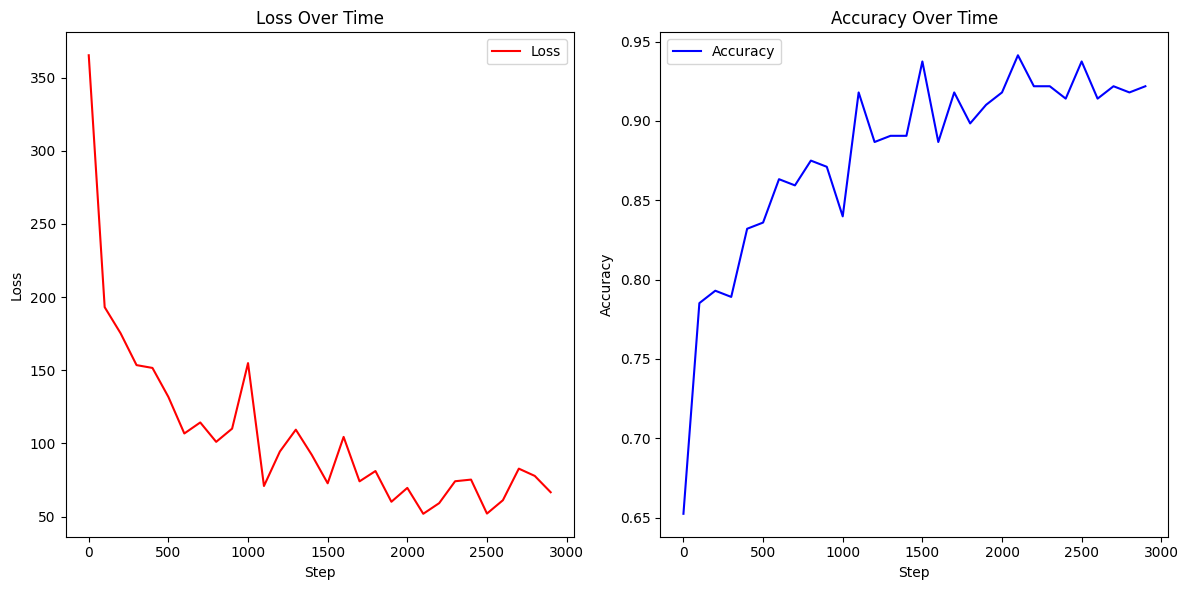

In [54]:
import matplotlib.pyplot as plt

# Кількість кроків (індекси кроків, де ми зберігали значення)
steps = range(0, len(loss_history) * display_step, display_step)

# Виведення графіку функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(steps, loss_history, label='Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

# Виведення графіку точності
plt.subplot(1, 2, 2)
plt.plot(steps, accuracy_history, label='Accuracy', color='blue')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

# Показати графіки
plt.tight_layout()
plt.show()


In [55]:
#Припустимо, що x_test і y_test — це ваші тестові дані
batch_size = 32  # розмір партії

# Створюємо датасет з тестових даних
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
# Обчислення точності навченої нейромережі на тестових даних
def test_model(neural_net, test_data):
    accuracy_total = 0
    num_batches = 0

    for batch_x, batch_y in test_data:
        # Передбачаємо значення на тестовій вибірці
        pred = neural_net(batch_x)
        
        # Обчислюємо точність для поточної партії
        batch_accuracy = accuracy(pred, batch_y)
        accuracy_total += batch_accuracy.numpy()
        num_batches += 1

    # Середня точність по всіх партіях
    avg_accuracy = accuracy_total / num_batches
    return avg_accuracy

# Приклад використання:
test_accuracy = test_model(neural_net, test_data)
print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.9051517571884984


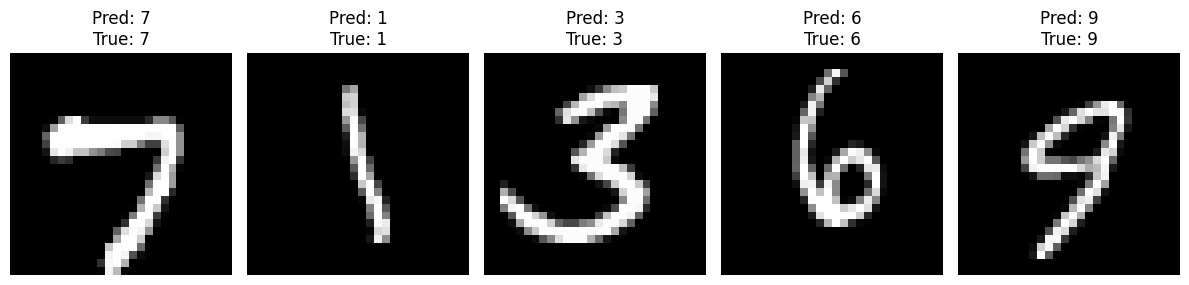

Model accuracy on sampled images: 100.00%


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Випадковий вибір 5 зображень з тестового набору
num_samples = 5
random_indices = np.random.choice(len(x_test), size=num_samples, replace=False)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Перетворення зображень у форму (5, 784) для подачі в нейромережу
sample_images = sample_images.reshape(num_samples, 28 * 28)

# Передбачаємо значення для вибраних зображень
sample_predictions = neural_net(sample_images)

# Отримуємо індекси класів з прогнозів
predicted_classes = tf.argmax(sample_predictions, axis=1).numpy()

# Виводимо зображення та відповідь нейромережі
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')  # Відображаємо зображення у градаціях сірого
    plt.title(f"Pred: {predicted_classes[i]}\nTrue: {sample_labels[i]}")  # Використовуємо sample_labels[i]
    plt.axis('off')

plt.tight_layout()
plt.show()

# Обчислюємо точність на вибраній вибірці
correct_predictions = np.sum(predicted_classes == sample_labels)
accuracy = correct_predictions / num_samples

print(f"Model accuracy on sampled images: {accuracy * 100:.2f}%")
